In [296]:
import torch
import torch.nn as nn
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import io
import math
from torch.utils.data import Dataset, DataLoader
import os
import re
import pandas as pd

In [132]:
# https://pytorch.org/data/main/torchdata.datapipes.iter.html
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58

In [6]:
root = "data"
with open(os.path.join(root, "train.csv")) as f:
        with open(os.path.join(root, "data.txt"), "w") as f2:
            for line in f:
                text_only = "".join(line.split(",")[1:])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' '))
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")
                f2.write(filtered.lower() + "\n")

# Example line
print(line.split(","))
print(type(line.split(",")))

['"2"', '"Nets get Carter from Raptors"', '"INDIANAPOLIS -- All-Star Vince Carter was traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning', ' Eric Williams', ' Aaron Williams', ' and a pair of first-round draft picks yesterday."\n']
<class 'list'>


In [8]:
# Generate the SentencePiece tokenizer
    # Text tokenizer and detokenizer
    # Unsupervised text tokenizer. It will tokenize words into subpieces instead of words
    # This function will create a set of subtokens to fit the set vocabulary size
    # There will always be enough subwords to subtokenize a dataset if you think about it :) -> max 2 length pairs = 26!
    # Saved in the home directory
generate_sp_model(os.path.join(root, "data.txt"), vocab_size=20000, model_prefix='SentencePiece/transformer')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/data.txt --model_prefix=SentencePiece/transformer --vocab_size=20000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/data.txt
  input_format: 
  model_prefix: SentencePiece/transformer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piec

In [13]:
# Class must inherit from Dataset to use DataLoader from torch
class AGNews(Dataset):
    def __init__(self, num_datapoints, set="train"):

        # Reads the file into a pandas DataFrame
        self.df = pd.read_csv(os.path.join(root, set + ".csv"), names=["Class", "Title", "Content"])

        # Replaces empty entries with a space
        self.df.fillna('', inplace=True)

        # Concatenates title and content into one heading 'article'
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

        # Clean up 'Article' column text
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", ' #38;': "&", ' #36;': "$", ' #151;': "-"}, regex=True)

        # Gets the first num_datapoints datapoints
        if num_datapoints is not None:
            self.df = self.df.head(num_datapoints)

    # To use for DataLoader
    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()
        # See if we can remove array indexing
        class_index = int(self.df.loc[index]["Class"]) - 1
        return class_index, text

    def __len__(self):
        return len(self.df)

# Create training and testing datasets from train.csv, test.csv, using AGNews class
train_dataset = AGNews(num_datapoints=10000, set="train")
test_dataset = AGNews(num_datapoints=10000, set="test")

In [338]:
# train_dataset.df

In [340]:
# test_dataset.df

In [126]:
# Create data loaders for the training and testing datasets
# Dataloaders allow for batching, shuffling

batch_size = 32  # Example batch size

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [136]:
# # Tokenize individual entries
# x = list(sp_tokenizer([text_batch[0]]))[0]
# x

In [18]:
# Tokenization and numericalization

# Load the trained SentencePiece model
sp_model = load_sp_model("transformer.model")

# Create a tokenizer function from file
sp_tokenizer = sentencepiece_tokenizer(sp_model)

# Create a numericalizer function from file
sp_numericalizer = sentencepiece_numericalizer(sp_model)

# Example usage
# for class_index, text_batch in dataloader_train:
    
#     # text_batch is a list of sentences
#     tokenized_text_batch = [list(sp_tokenizer([t]))[0] for t in text_batch]

#     numericalized_text_batch = [list(sp_numericalizer([t]))[0] for t in text_batch]
    
#     print(f"Original Text: {text_batch[0]}")
    
#     print(f"Tokenized Text: {tokenized_text_batch[0]}")
    
#     print(f"Numericalized Text: {numericalized_text_batch[0]}")
    
#     break

In [328]:
# text_batch[1]

In [26]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
vocab = build_vocab_from_iterator(yield_tokens("transformer.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [30]:
# print(vocab['<pad>'])  # Should print the index of <pad>
# print(vocab['<sos>'])  # Should print the index of <sos>
# print(vocab['<eos>'])  # Should print the index of <eos>
# print(vocab['<unk>'])  # Should print the index of <unk>
# print(vocab['▁the'])   # Should print the index of ▁the (if present)
# print(vocab['unknown_token'])  # Should print the index of <unk> as it's not in vocab

In [44]:
# Maximum sequence length for text inputs
max_len = 160

# Data transform to turn text into vocab token
# Text transformation pipeline aliased T
text_transform = T.Sequential(
    # Tokenize with pretrained Tokenizer
    T.SentencePieceTokenizer("transformer.model"),
    # Converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at beginning of each sentence. 
    # 1 because the index for <sos> in vocabulary is 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 
    # 2 because the index for <eos> in vocabulary is 2
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length
    # T.ToTensor(padding_value=vocab['<pad>']),
)

# Custom padding function
def pad_sequence(seq, max_len, padding_value):
    if len(seq) < max_len:
        seq += [padding_value] * (max_len - len(seq))
    return seq[:max_len]


In [80]:
# Example text data
example_texts = ["This is an example sentence.", "a a, a, a, a, a, a, a", "b b b b b b b"]

padding_idx = 0

# Loop through all examples, separated by a comma
transformed_texts = [pad_sequence(text_transform([text])[0], max_len, padding_idx) for text in example_texts]

# Convert to tensor and stack into a batch
batch_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in transformed_texts])

print(batch_tensor)
print(batch_tensor.shape)

tensor([[    1,  3686,     3,  1556, 11578,  5040,  9237, 16819,    50,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [130]:
class TokenDrop(nn.Module):
    """ For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    prob (float): probability of dropping a token
    pad_token (int): index for the <pad> token
    num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p = prob
        # Create a mask where 1 means we will replace that token
        # Discrete probability distribution
        # Here we want to treat the ones as the indexes to drop
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # Only replace if the token is not a special token
        # Ones or zeros. If cannot drop, 0, if can drop, 1
        can_drop = (sample >= self.num_special).long()
        # Multiply together to get the corresponding tokens to be dropped and not dropped
        # Here, 1 represents drop, 0 represents do not drop
        mask = mask * can_drop

        # Make a mask of pad_token to use for replacing dropped indices with the pad_token
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        # Sample is the original sample
        # THe mask indicates what tokens can be replaced (0 to not be replaced, 1 to be replaced)
        # Replace_with is a list of of the pad_token tokens
        # Here, (1-mask) creates the complement mask. (now, 0 indicates drop, 1 indicates to not drop)
        # 1-1 = 0, 1-0 = 0
        # Multiplying by sample, retains the original tokens that are not to be kept, and applies the mask on the sample
        # Here, mask * replace_with does elementwise multiplication and adds the corresponding pad_token to the tokens replaced
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [108]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, hidden_size):
        super(SinusoidalPosEmb, self).__init__()
        self.hidden_size = hidden_size

    def forward(self, x):
        # Get the device of the input tensor
        device = x.device
        
        # Calculate half of the hidden size
        half_dim = self.hidden_size // 2
        
        # Compute the scaling factor
        emb_scale = math.log(10000) / (half_dim - 1)
        
        # Generate the sinusoidal frequencies
        emb_frequencies = torch.exp(torch.arange(half_dim, device=device) * -emb_scale)
        
        # Apply frequencies to the positions
        emb = x[:, :, None] * emb_frequencies[None, None, :]
        
        # Concatenate sin and cos functions to form positional embeddings
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb


In [208]:
class NanoTransformer(nn.Module):
    """
        This class implements a simplified Transformer model for sequence classification. 
        It uses an embedding layer for tokens, sinusoidal positional embeddings, 
        a Transformer, and a Linear layer.
        
        num_emb: The number of unique tokens in the vocabulary. (vocab_size)
        output_size: The size of the output layer (number of classes). (4)
        hidden_size: The dimension of the hidden layer in the Transformer block (default: 128)
        num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, num_emb, output_size, hidden_size=128, num_heads=4):
        
        # Inherits from nn.Module's attributes
        super(NanoTransformer, self).__init__()

        # Create an embedding for each token
        self.embedding = nn.Embedding(num_emb, hidden_size) # (vocab_size, 128)
        
        # Scaling down the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        
        # Positional embedding
        self.pos_emb = SinusoidalPosEmb(hidden_size) # (128)

        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads = num_heads, batch_first = True)

        # Linear layer
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size), # (batch_size, 128, 128)
                                 nn.LayerNorm(hidden_size), # (batch_size, 128, 128)
                                 nn.ELU(), # (batch_size, 128, 128)
                                 nn.Linear(hidden_size, hidden_size)) # (batch_size, 128, 128)
        
        self.fc_out = nn.Linear(hidden_size, output_size) # (batch_size, 128, 128)

    def forward(self, input_seq):
        # batch_size, time_steps
        batch_size, l = input_seq.shape # (32, 160)

        input_embs = self.embedding(input_seq) # (32, 160) -> (32, 160, 128)
        
        # Add a unique embedding to each token embedding depending on it's position in the sequence
        seq_indx = torch.arange(l) # (160)
        
        pos_emb = self.pos_emb(seq_indx.repeat(batch_size, 1)) # (1, 160, 128) -> (32, 160, 128)
        
        embs = input_embs + pos_emb # (32, 160, 128) + (32, 160, 128)
        
        output, attn_map = self.multihead_attn(embs, embs, embs) # (32, 160, 128)
        
        output = self.mlp(output) # (32, 160, 128)

        return self.fc_out(output), attn_map # (32, 160, 4)

In [280]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Embedding size
hidden_size = 256

# Learning rate for the optimizer
learning_rate = 1e-4

# Number of epochs for training
nepochs = 20

# Batch size for data loaders
batch_size = 128

# Maximum sequence length for text inputs
max_len = 128

output_size = 4

num_heads = 4

time_steps = 160

# Create the Transformer model
tf_classifier = NanoTransformer(num_emb=len(vocab), output_size=4, hidden_size = hidden_size, num_heads = 4).to(device)

# Initialize the optimizer
optimizer = optim.Adam(tf_classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

# Cosine annealing scheduler to decay the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Custom transform to randomly replace a token with <pad>
td = TokenDrop(prob=0.5)

# Training and testing loss
training_loss_list = []
test_loss_list = []

# Training and testing accuracy
training_acc_list = []
test_acc_list = []

train_acc = 0

test_acc = 0

In [282]:
# Number of model parameters
num_model_params = 0
for param in tf_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 5517060 (Approximately 5 Million) Parameters!


In [292]:
# Loop over each epoch
for epoch in range(nepochs):
    
    print('Accuracy: Train %.2f%%, Test %.2f%%' %(train_acc * 100, test_acc * 100))
    
    tf_classifier.train()
    
    steps = 0
    
    # Loop over each batch in the training dataset
    for batch_idx, (labels, texts) in enumerate(dataloader_train):
        # Number of examples in the batch
        batch_size = labels.shape[0]
        
        # Transform the text to tokens
        # text_tokens = text_transform(list(texts)).to(device)

        transformed_texts = [pad_sequence(text_transform([text])[0], max_len, padding_idx) for text in texts]
        # Convert to tensor and stack into a batch
        batch_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in transformed_texts])
        
        labels = labels.to(device)

        # TokenDrop
        batch_tensor = td(batch_tensor)
 
        # Get the model predictions
        pred, _ = tf_classifier(batch_tensor)

        # Compute the loss using cross-entropy loss
        loss = loss_fn(pred[:, 0, :], labels)
        
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss.append(loss.item())
        
        # Update training accuracy
        train_acc += (pred[:, 0, :].argmax(1) == labels).sum()
        steps += batch_size
    
    # Calculate average training accuracy
    train_acc = (train_acc / steps).item()
    training_acc_list.append(train_acc)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Set the model to evaluation mode
    tf_classifier.eval()
    steps = 0
    
    # Loop over each batch in the testing dataset
    with torch.no_grad():
        for batch_idx, (labels, texts) in enumerate(dataloader_train):
            batch_size = labels.shape[0]
            # Transform the text to tokens and move to the GPU
            # text_tokens = text_transform(list(texts)).to(device)
            # padded_tokens = pad_sequence(text_tokens, max_len, padding_idx)
            transformed_texts = [pad_sequence(text_transform([text])[0], max_len, padding_idx) for text in texts]
            # Convert to tensor and stack into a batch
            batch_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in transformed_texts])
            
            labels = labels.to(device)

            # Get the model predictions (Do not return attention map)
            pred, _ = tf_classifier(batch_tensor)

            # Compute the loss using cross-entropy loss
            loss = loss_fn(pred[:, 0, :], labels)
            # Corresponds to the start of sentence token
            test_loss.append(loss.item())

            # Update testing accuracy
            test_acc += (pred[:, 0, :].argmax(1) == labels).sum()
            steps += batch_size

        # Calculate average testing accuracy
        test_acc = (test_acc / steps).item()
        test_acc_list.append(test_acc_list)

Accuracy: Train 27525.42%, Test 108325.23%


KeyboardInterrupt: 

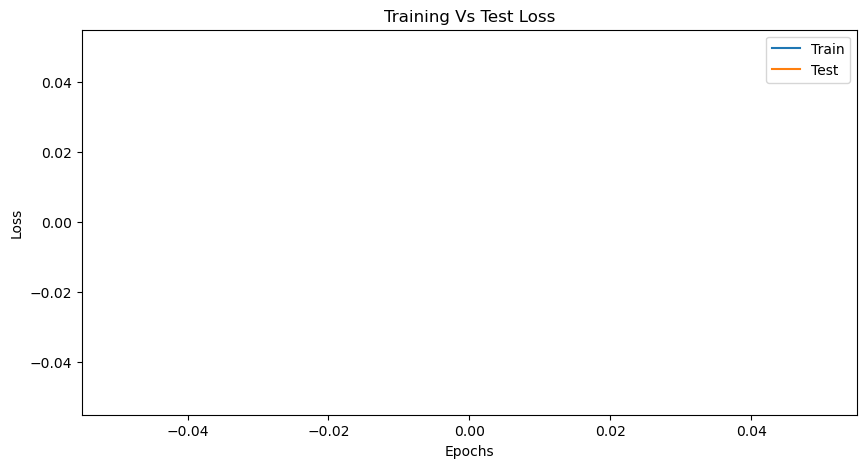

In [298]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_list)), training_loss_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_list)), test_loss_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")


KeyboardInterrupt



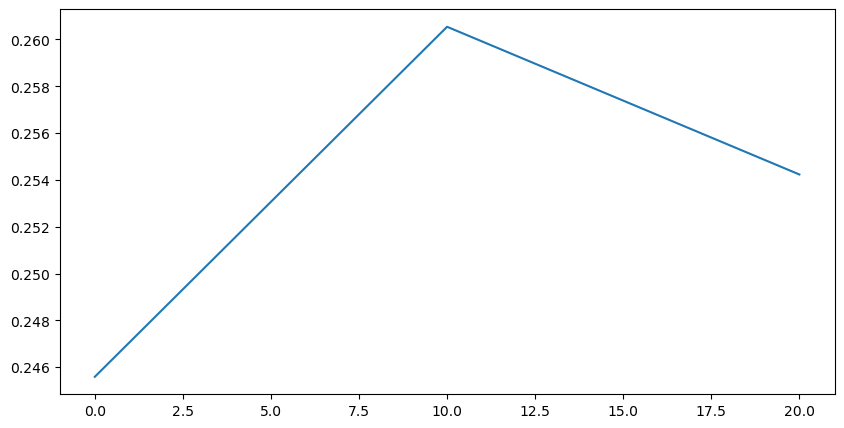

In [302]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_list)), training_acc_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_list)), test_acc_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_list) * 100))

In [306]:
ag_news_classes = [
    "World",
    "Sports",
    "Business",
    "Science/Technology"
]

with torch.no_grad():
    label, text = next(iter(dataloader_train))
    text_tokens = text_transform(list(text)).to(device)
    pred, attention_map = tf_classifier(text_tokens)

AttributeError: 'list' object has no attribute 'to'

In [310]:
test_index = 3

# Choose a text index smaller than the total number in the batch!
assert test_index < label.shape[0]

# Select the attention map for a single sample and the first attention head
att_map = attention_map[test_index, 0]
pred_class = ag_news_classes[pred[test_index, -1].argmax().item()]
top5 = att_map.argsort(descending=True)[:5]
top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())


print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])

print("\nTop 5 Tokens:")
print(top5_tokens)

NameError: name 'attention_map' is not defined

In [308]:
_ = plt.plot(att_map.cpu().numpy())
_ = plt.title("Attention score per token")

NameError: name 'att_map' is not defined